# Differentiable Physics IV: Numerical Methods for Hyperbolic PDEs

Considering a second order PDE's:

$$A \frac{\partial ^ 2 u}{\partial x^2} + 2B \frac{\partial ^ 2 u}{\partial y \partial x} + C \frac{\partial ^ 2 u}{\partial y^2} = 0 $$

We can distinguish three cases, for each of which different numerial methods are applicable:

| Case | Name | Intuition | Numerical method | Example |
| --- | --- | --- | --- | --- |
| $B^2 - AC > 0$ | Elliptic | Equilibrium States <br/>--> no discontinuities  | Jacobi, SOR, FFT, Multigrid | Poisson Equation |
| $B^2 - AC = 0$ | Parabolic | Diffusion, Smoothing | Crank-Nicolson | Diffusion, Heat Equation |
| $B^2 - AC < 0$ | Hyperbolic | Waves | Lax, Upwind, Lax-Wendrof, Mac Cormack | Wave Equation |


We are going to focus on the hyperbolic case, because our main goal is to solve the navier stokes equations, which are hyperbolic.

## 1D Adevection & Upwind

Before looking at the more complex NS equations, we are trying to get an intuition for how to solve the more simple 1D advection equation. The advection equation is given by:

$$\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0 \tag{1}$$

where $a$ is the advection speed. We can interpret this equation as a transport equation, where the function $u$ is transported with the speed $a$. Using the Taylor expansion, we can find a solution for $u^{n+1}$ in terms of $u^n$:

$$u^{n+1} = u^n + \Delta t \frac{\partial u}{\partial t} + \frac{\Delta t^2}{2} \frac{\partial ^2 u}{\partial t^2} + \mathcal{O}(\Delta t^3)$$

Using (1) we can substitute the time derivatives:

$$u^{n+1} = u^n - a \Delta t \frac{\partial u}{\partial x} + \frac{a^2 \Delta t^2}{2} \frac{\partial ^2 u}{\partial t^2} + \mathcal{O}(\Delta t^3)$$

Using the finite difference method with the central difference we can replace the derivatives with the following approximations:

$$\frac{\partial u}{\partial x} \approx \frac{u_{i+1} - u_{i-1}}{2 \Delta x}$$

$$\frac{\partial ^2 u}{\partial x^2} \approx \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta x^2}$$

Substituting these approximations into the Taylor expansion we get:

$$u^{n+1}_i = u^n_i - \frac{a \Delta t}{2 \Delta x} (u_{i+1} - u_{i-1}) + \frac{a^2 \Delta t^2}{2 \Delta x^2} (u_{i+1} - 2 u_i + u_{i-1}) + \mathcal{O}(\Delta t^3)$$

We can simplify this equation by defining the Courant number $C = \frac{a \Delta t}{\Delta x}$:

$$u^{n+1}_i = u^n_i - \frac{C}{2} (u_{i+1} - u_{i-1}) + \frac{C^2}{2} (u_{i+1} - 2 u_i + u_{i-1}) + \mathcal{O}(\Delta t^3) \tag{2}$$

Equation (2) can easily be implemented in python:


In [63]:
import numpy as np

def upwind_step(u : np.ndarray, dt : float, dx : float,  a : float) -> np.ndarray:
    C = a * dt / dx
    dudx = np.roll(u, 1) - np.roll(u, -1)

    du2dx2 = np.roll(u, -1) - 2 * u + np.roll(u, 1)

    return u + C/2 * dudx + C**2 / 2 * du2dx2

/tmp/ipykernel_319/3617798481.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


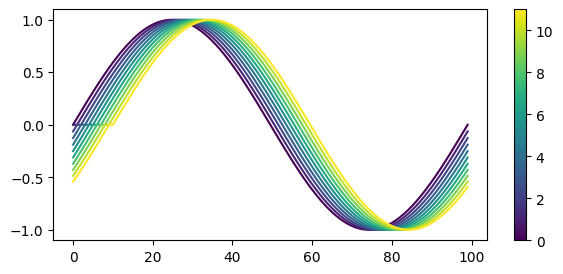

In [64]:
import matplotlib.pyplot as plt
    
# simple wave for x
x = np.sin(2 * np.pi * np.linspace(0, 1, 100) * 1)

dt = 1
dx = 1
a = 1
xs = [x]

for i in range(10):
    x = upwind_step(x, dt, dx, a)
    xs.append(x)

plt.figure(figsize=(7, 3))
colors = plt.cm.viridis(np.linspace(0, 1, len(xs)))
for i, x in enumerate(xs):
    plt.plot(x, '-', label=f"t={i}", color=colors[i])

# add color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=len(xs)))

sm.set_array([])
plt.colorbar(sm)

Lets look at some of the numerical methods for hyperbolic PDEs:

| Method | Intuition | Example |
| --- | --- | --- |
| Lax | Explicit, first order in time and space | Wave Equation |
| Upwind | Explicit, first order in time and space | Wave Equation |
| Lax-Wendrof | Explicit, second order in time and space | Wave Equation |

## Lax Wendrof

What if the equation is non-linear? Lets assume an equation of the form:

$$\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0 \tag{3}$$

where $f$ is a function on $u$. The Linear 1D advection equation is a special case of this equation, where $f(u) = a \cdot u$.

We can take the time derivative of the equation and obtain:

$$\frac{\partial^2 u}{\partial t^2} = - \frac{\partial^2 f(u)}{\partial t \partial x}$$

which is equivalent to:

$$\frac{\partial^2 u}{\partial t^2} = - \frac{\partial }{\partial x} \frac{\partial f(u)}{\partial t} \tag{4}$$

At this point remeber the chain rule:

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z} \frac{\partial z}{\partial x}$$


Using the chain rule we can rewrite (4) as:

$$\frac{\partial^2 u}{\partial t^2} = -\frac{\partial}{\partial x} \left( \frac{\partial f(u)}{\partial u} \frac{\partial u}{\partial t} \right)$$

We then use (3) to substitute $\frac{\partial u}{\partial t}$:

$$\frac{\partial^2 u}{\partial t^2} = -\frac{\partial}{\partial x} \left( \frac{\partial f(u)}{\partial u} \left(- \frac{\partial f(u)}{\partial x} \right) \right)$$

We define $A$ as the Jacobian of $f$:

$$A = \frac{\partial f(u)}{\partial u}$$

and obtain:

$$\frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x} \left( A \frac{\partial f(u)}{\partial x} \right) \tag{5}$$



Remember the taylor expansion to find a solution for $u^{n+1}$ in terms of $u^n$:

$$u^{n+1} = u^n + \Delta t \frac{\partial u}{\partial t} + \frac{\Delta t^2}{2} \frac{\partial ^2 u}{\partial t^2} + \mathcal{O}(\Delta t^3)$$

We can insert (3) and (5) to obtain:

$$u^{n+1} = u^n - \Delta t \frac{\partial f(u)}{\partial x} + \frac{\Delta t^2}{2} \frac{\partial}{\partial x} \left( A \frac{\partial f(u)}{\partial x} \right) + \mathcal{O}(\Delta t^3)$$

Where we can use the central difference to approximate the derivatives:

$$\frac{\partial f(u)}{\partial x} \approx \frac{f(u_{i+1}) - f(u_{i-1})}{2 \Delta x}$$

$$\frac{\partial}{\partial x} \left( A \frac{\partial f(u)}{\partial x} \right) \approx 
\frac{ A_{i+0.5} (f(u_{i+1}) - f(u_i)) - A_{i-0.5} (f(u_{i}) - f(u_{i-1}))}{\Delta x}$$

Substituting these approximations into the Taylor expansion we get:

$$u^{n+1}_i = u^n_i - \frac{\Delta t}{2 \Delta x} (f(u_{i+1}) - f(u_{i-1})) + \frac{\Delta t^2}{2 \Delta x^2} ( A_{i+0.5} (f(u_{i+1}) - f(u_i)) - A_{i-0.5} (f(u_{i}) - f(u_{i-1}))) + \mathcal{O}(\Delta t^3)$$

This method requires a lot of evaluations of the jacobi matrix $A$ which is costly.

## Mac Cormack

A better method which retains second order accuracy in time and space is the Mac Cormack method. Mac Cormack is a predictor-corrector method.

First we make a prediction for $\bar{u}^{n+1}$ based on the taylor expansion at the previous time step:

$$\bar{u}^{n+1} = u^n - \frac{\Delta t}{\Delta x} \left( f(u_{i}) - f(u_{i-1}) \right)$$

We then use the average between the estimate for the future timestep and the current timestep to calculate the correction:

$$u^{n+1} = \frac{1}{2} \left( u^n + \bar{u}^{n+1}\right) - \frac{\Delta t}{2 \Delta x} \left( f(\bar{u}^{n+1}_{i}) - f(\bar{u}^{n+1}_{i-1})  \right)$$



## Burgers Equation

The Burgers equation without diffusion looks as follows:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

which we can rewrite using the flux function $f(u) = \frac{u^2}{2}$ as:

$$\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0$$

Which allows us to use the Mac Cormack method to solve the equation.

In [56]:
from typing import Callable

def flux(u : np.ndarray) -> np.ndarray:
    return u**2 / 2

def burger_step(u : np.ndarray, dt : float, dx : float) -> np.ndarray:
    dtdx = dt / dx

    u_pred = u - dtdx * (flux(u)) - flux(np.roll(u, 1))

    return (u + u_pred)/2 - dtdx/2 * (flux(u_pred) - flux(np.roll(u_pred, -1)))

/tmp/ipykernel_319/86157441.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


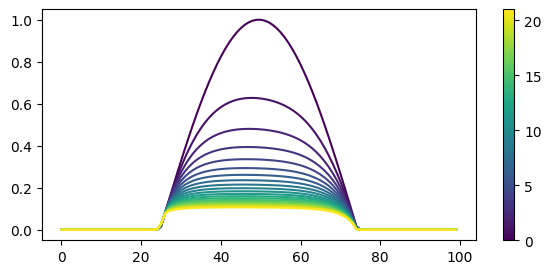

In [61]:
x = np.cos(2 * np.pi * (np.linspace(0, 1, 100) + 0.5))
x = np.maximum(0, x)

dt = 0.5
dx = 1
xs = [x]

for i in range(20):
    x = burger_step(x, dt, dx)
    xs.append(x)

plt.figure(figsize=(7, 3))
colors = plt.cm.viridis(np.linspace(0, 1, len(xs)))
for i, x in enumerate(xs):
    plt.plot(x, '-', label=f"t={i}", color=colors[i])

# add color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=len(xs)))

sm.set_array([])
plt.colorbar(sm)

